# Bias and Variance
In this notebook, we will assess the relative performance of the various classifiers models we have explored so far.

**Learning Objectives**

By the end of this notebook, you should be able to 
1. Split data into sets used for training and testing
2. Explain the concepts of bias and variance in classifier models
3. Identify bias and variance in model results

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

### Yet Another Classification Problem

Continuing with our theme of classification, we're going to look at another classification problem - but one that's not a nice as the ones we've seen already. In this notebook, we're going to explore some data on phytoplankton collected in the in the San Francisco Bay area that is accessible [HERE](https://www.sciencebase.gov/catalog/item/598b755de4b09fa1cb0eadd9).

Let's read in the data set into a data frame:

In [3]:
df = pd.read_csv('Phytoplankton_San_Francisco_Bay_2017-2018.csv', encoding='latin1')

If you peek inside this data set, you'll find that there are LOTs of different species identified here. To simplify this data set a bit, let's limit it to just the measurements pertaining to *Thalassiosira spp.* and *Nitzschia spp.*:

In [4]:
df = df[df['Taxonomic Identification'].isin(['Thalassiosira spp.','Nitzschia spp.'])]

These are two common types of phytoplankton in California coastal waters and are pictured in the microscope images below:

<img src="Thalassiosira_Nitzschia.png" alt="Thalassiosira and Nitzschia" width="500">

These images come from the Kudela lab at UCSB, More information is available [HERE](http://oceandatacenter.ucsc.edu/PhytoGallery/Diatoms/thalassiosira.html) and [HERE](http://oceandatacenter.ucsc.edu/PhytoGallery/Diatoms/pseudo%20nitzschia.html).

Just like our previous classification problems, let's encode these species with the IDs 0 and 1:

In [5]:
df.loc[df['Taxonomic Identification']=='Thalassiosira spp.', "Species_ID"] = 0
df.loc[df['Taxonomic Identification']=='Nitzschia spp.', "Species_ID"] = 1

To explore this data, let's take a look at a quick plot. Here, we'll investigate how the species differ in their densities and cell volumes:

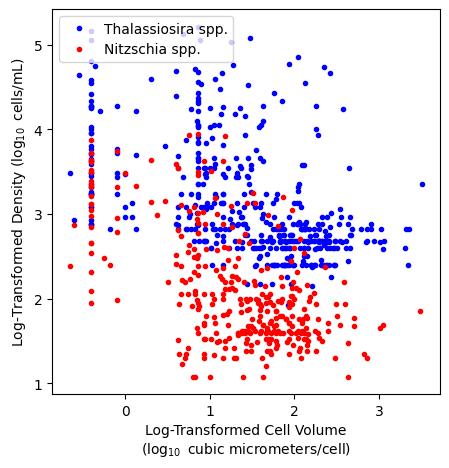

In [6]:
plt.figure(figsize=(5,5))
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==0]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==0]),
         'b.',label='Thalassiosira spp.')
plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==1]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==1]),
         'r.',label='Nitzschia spp.')
plt.ylabel('Log-Transformed Density ($\\log_{10}$ cells/mL)')
plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
plt.legend(loc=2)
plt.show()

As we can see, the *Thalassiosira spp.* cells tend to have higher densities and cell volumes than *Nitzschia spp.*. It's important to note here that this plot is shown on a **log-scale**. That is, the data has been transformed to show the magnitude of the data rather than the absolute data. This is common in data sets that span many orders of magnitude, like cell volumes and densities. 

Nonetheless, we can see that there are differences between the two species in this data set. If this classification could be modeled, we may be able to identify these species by their counts alone rather than having to identify them under a microscope! Let's see how all of our different classifiers do on this problem.

## Testing Different Classifiers

In this notebook, we'll continue to rely on the classification tools provided in the `scikit-learn` package. First, let's prep our design matrix and our classification data:

In [8]:
X = np.column_stack([np.log10(df['Density (cells/mL)']), np.log10(df['Cell Volume (cubic micrometers/cell)'])])
y = df['Species_ID']

Since all of the model written in `scikit-learn` have the same structure, we can use them in exactly the same way (this is the object-oriented idea of polymorphism). Let's make a list of our models:

In [9]:
models = [Perceptron(),
          LogisticRegression(),
          KNeighborsClassifier(n_neighbors=3),
          DecisionTreeClassifier(max_depth=10)
        ]

Next we can fit all of our models to our data:

In [10]:
for model in models:
    model.fit(X, y)

Easy!

Since we're going to make a number of the same plots, let's define some bounds to work with:

In [11]:
min_x = -1
max_x = 4
min_y = 1
max_y = 6

Since all of these models are written in the same way, we can apply them using the exact same code. Let's write a generalized function to apply the models to our classification dataset.

In [12]:
def classify_domain(model, X, y):
    x1 = np.linspace(min_x, max_x, 100)
    x2 = np.linspace(min_y, max_y, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Y_pred = model.predict(np.column_stack([X1.ravel(), X2.ravel()])).reshape(X1.shape)
    return(X1, X2, Y_pred)

Give this function, we can compare and contrast the model results:

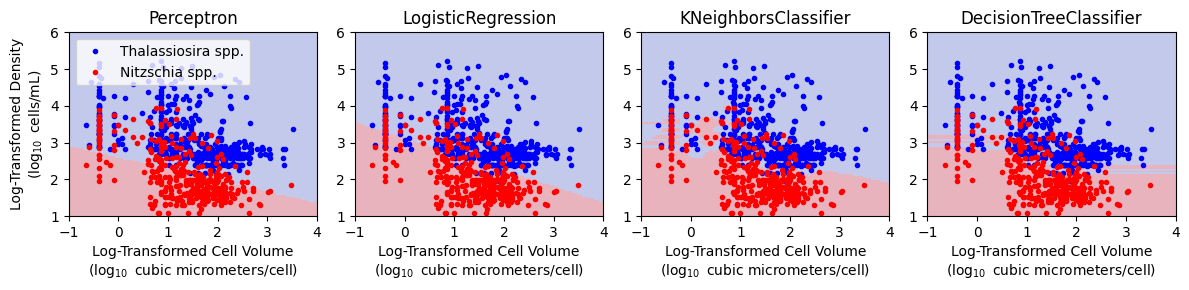

In [13]:
fig = plt.figure(figsize=(12,3))

for m, model in enumerate(models):
    X1, X2, Y_pred = classify_domain(model, X, y)
    
    plt.subplot(1, 4, m + 1)
    plt.pcolormesh(X1, X2, Y_pred, alpha=0.3, cmap='coolwarm', shading='auto')
    plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==0]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==0]),
         'b.',label='Thalassiosira spp.')
    plt.plot(np.log10(df['Density (cells/mL)'][df['Species_ID']==1]),
         np.log10(df['Cell Volume (cubic micrometers/cell)'][df['Species_ID']==1]),
         'r.',label='Nitzschia spp.')

    plt.title(model.__class__.__name__)
    plt.gca().set_xlim([min_x, max_x])
    plt.gca().set_ylim([min_y, max_y])
    plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
    
    if m==0:
        plt.ylabel('Log-Transformed Density\n($\\log_{10}$ cells/mL)')
        
        plt.legend(loc=2)
        
plt.tight_layout()
plt.show()

### Which model is the best?

At this point, we are confronted with an issue - which of these models are we supposed to use? They are giving similar results, it seems, but which one is the best?

One idea to to take a look at the overall loss:

In [14]:
# compute the loss for each model
def compute_loss(model, X, y):
    y_pred = model.predict(X)
    loss = np.sum(y_pred != y)  # misclassifications
    loss = loss / len(y)        # normalize by number of samples
    return loss

# make a list of the losses
losses = [compute_loss(model, X, y) for model in models]

In [15]:
model_names = [model.__class__.__name__ for model in models]

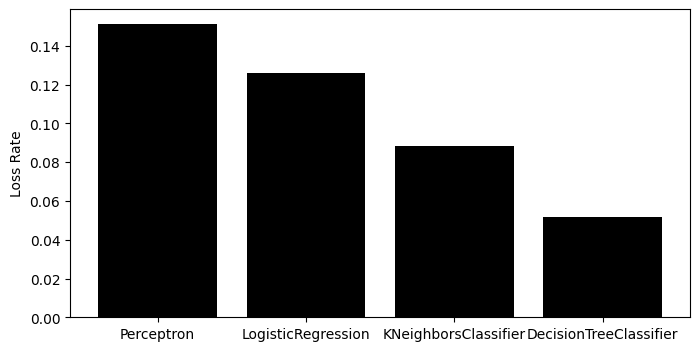

In [16]:
# make a bar plot of the losses
plt.figure(figsize=(8,4))
plt.bar(model_names, losses, color='k')
plt.ylabel('Loss Rate')
plt.xlabel('')
plt.show()

In the above plot, we see that the Decision Tree model has the lowest number of misclassications, followed by the KNN classifier. But does this really mean that these models are the "best"? Let's take a look back at the predictions:

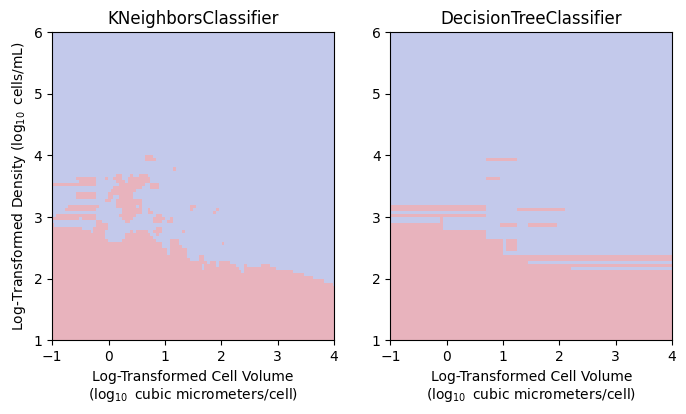

In [17]:
# plot just the predictions for the KNN and DT models
plt.figure(figsize=(8, 4))
for m, model in enumerate(models[2:4]):  # only KNN and DT
    X1, X2, Y_pred = classify_domain(model, X, y)
    
    plt.subplot(1, 2, m + 1)
    plt.pcolormesh(X1, X2, Y_pred, alpha=0.3, cmap='coolwarm', shading='auto')
    
    plt.title(model.__class__.__name__)
    plt.gca().set_xlim([min_x, max_x])
    plt.gca().set_ylim([min_y, max_y])
    if m==0:
        plt.ylabel('Log-Transformed Density ($\\log_{10}$ cells/mL)')
    plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')

In your opinion, do these model represent the character of the data? What is going on here?

### Training vs Testing

So far, we have tested our model on all of the available data. However, this leaves us with no *independent* way to assess our model results. To get around this issue, we need to split our data in data used for training and data used for testing. Say, for example, we take 30% of our data out of our dataset, and set it aside. In this way, our models can't memorize our data. Luckily, `scikit-learn` has a tool for this:

In [20]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=17)

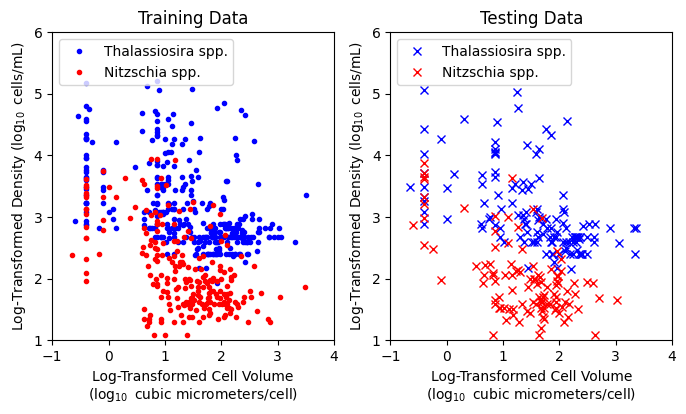

In [21]:
# plot the training and testing data
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], 'b.', label='Thalassiosira spp.')
plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'r.', label='Nitzschia spp.')
plt.gca().set_xlim([min_x, max_x])
plt.gca().set_ylim([min_y, max_y])
plt.ylabel('Log-Transformed Density ($\\log_{10}$ cells/mL)')
plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
plt.legend(loc=2)
plt.title('Training Data')

plt.subplot(1, 2, 2)
plt.plot(X_test[y_test==0, 0], X_test[y_test==0, 1], 'bx',label='Thalassiosira spp.')
plt.plot(X_test[y_test==1, 0], X_test[y_test==1, 1], 'rx', label='Nitzschia spp.')
plt.gca().set_xlim([min_x, max_x])
plt.gca().set_ylim([min_y, max_y])
plt.ylabel('Log-Transformed Density ($\\log_{10}$ cells/mL)')
plt.xlabel('Log-Transformed Cell Volume\n($\\log_{10}$ cubic micrometers/cell)')
plt.legend(loc=2)
plt.title('Testing Data')
plt.show()

Just like before, we will fit our models to the data, but this time, we will only use the training data for the model fitting. The testing data will be used to see how the model is performing. Let's redefine our models and now only fit them on the training data.

In [22]:
models = [Perceptron(),                         # Perceptron model
          LogisticRegression(),                 # Logistic Regression model
          KNeighborsClassifier(n_neighbors=3),  # K-Nearest Neighbors model
          DecisionTreeClassifier(max_depth=10)] # Decision Tree model

for model in models:
    model.fit(X_train, y_train)

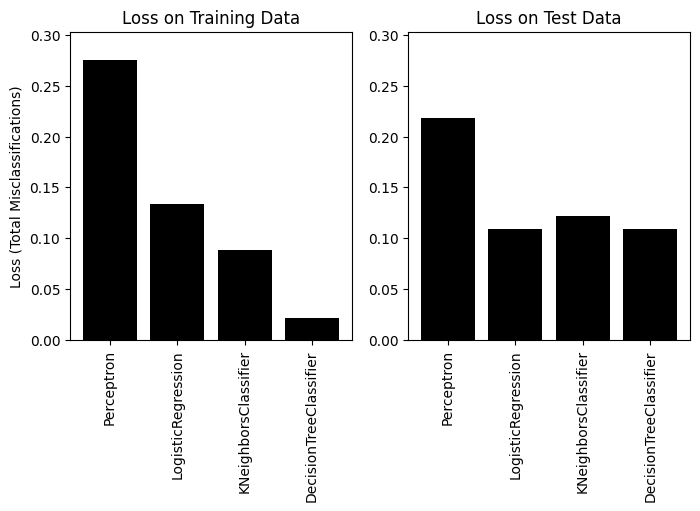

In [23]:
# make a list of the losses
losses_train = [compute_loss(model, X_train, y_train) for model in models]
losses_test = [compute_loss(model, X_test, y_test) for model in models]

# make a bar plot of the losses
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.bar([model.__class__.__name__ for model in models], losses_train, color='k')
plt.ylabel('Loss (Total Misclassifications)')
plt.title('Loss on Training Data')
plt.xticks(rotation=90)
plt.ylim([0,1.1*np.max(losses_train)])

plt.subplot(1, 2, 2)
plt.bar([model.__class__.__name__ for model in models], losses_test, color='k')
plt.title('Loss on Test Data')
plt.xticks(rotation=90)
plt.ylim([0,1.1*np.max(losses_train)])
plt.show()

Now, when comparing the losses on the training data, the story is much different! The KNN and decision tree models are outperformed by the logistic regression and support vector machine models. In this scenario, the latter models have *memorized* how to fit the data they were given well, but they are not very good at predicting new data. This is an example of **overfitting**. By contrast, the other three models showcase **underfitting** - even after training, they have high loss function values. Of course, that's not very suprising given these three models are all linear models.

## Bias and Variance

When a model is underfit to a given data set, we say that the model has a high **bias**. In this case, the model is likely overly simplistic and cannot distinguish important features in the data set. 

When a model is overfit to a given data set, then it will perform well on the training data but it will not perform well on unseen testing data. This error resulting from changes in the input data is called **variance**. 

When building models, there is a *tradeoff* betwen bias and variance. We want our models to pick out important features in our dataset but we don't want them to memorize our data. In other words, we want our models to be just complex enough to get the patterns right, but not overly complex so that it is not useful when provided with unseen data.

Question:
Which models above have high variance?
Which models have high bias?

## $k$-Fold Cross Validation

In the above example of training and testing, we set aside a given amount of data as a test data set and we used the rest for testing. We might also imagine that this split itself could mislead us about the potential bias or variance in our model.

To combate potential issues associated with a given split, we could also imagine training our model many times on different splits - this is the idea of $k$-fold cross validation. In this process, we split the full data set into $k$ subsets and then train and test the model $k$ times, each time leaving one of the "folds" out for testing. Let's see how this works using `scikit-learn`: 

In [26]:
# Define k-fold cross-validator
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=17)

# make a list to store all of the losses for each model
all_fold_losses = []

y = np.array(y)

for model in models:

    # Track accuracy for each fold
    fold_losses = []
    
    for (train_indices, test_indices) in kf.split(X):
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        loss = compute_loss(model, X_test, y_test)
        fold_losses.append(loss)
    
    # add the model losses to the big list
    all_fold_losses.append(fold_losses)

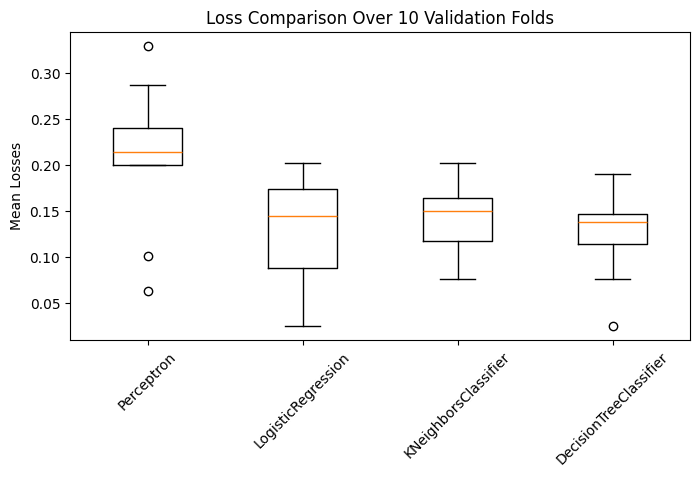

In [27]:
plt.figure(figsize=(8,4))

# Create the box plot
plt.boxplot(all_fold_losses)

# Add labels and title
plt.title("Loss Comparison Over 10 Validation Folds")
plt.ylabel("Mean Losses")
plt.gca().set_xticklabels([model.__class__.__name__ for model in models],
                         rotation=45)

# Show the plot
plt.show()

**Key Takeaways**

1. Bias and variance describe a model's "fit" to data and characterize the expected performance of a model to unseen data.
2. These metrics are computed by dividing the data into different subsets for testing and training.